<a href="https://colab.research.google.com/github/fvt1h/Encryptix/blob/main/Genre_Classification_Dataset_IMDb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classification with Logistic Regression and Naive Bayes

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hijest/genre-classification-dataset-imdb
!unzip genre-classification-dataset-imdb

Dataset URL: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb
License(s): other
genre-classification-dataset-imdb.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  genre-classification-dataset-imdb.zip
replace Genre Classification Dataset/description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Genre Classification Dataset/description.txt  
replace Genre Classification Dataset/test_data.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Genre Classification Dataset/test_data.txt  
replace Genre Classification Dataset/test_data_solution.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Genre Classification Dataset/test_data_solution.txt  
replace Genre Classification Dataset/train_data.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Genre Classification Dataset/train_data.txt  


##EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("Genre Classification Dataset/train_data.txt", sep=":::", names=["title", "genre", "description"], engine="python")
df_test = pd.read_csv("Genre Classification Dataset/test_data.txt", sep=":::", names=["id", "title", "description"], engine="python")

###Train data exploration

In [3]:
df_train.head()

,title,genre,description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
df_train.describe()

,title,genre,description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
df_train.isnull().sum

<bound method DataFrame.sum of        title  genre  description
1      False  False        False
2      False  False        False
3      False  False        False
4      False  False        False
5      False  False        False
...      ...    ...          ...
54210  False  False        False
54211  False  False        False
54212  False  False        False
54213  False  False        False
54214  False  False        False

[54214 rows x 3 columns]>

In [7]:
df_train.duplicated().sum()

0

###Test data exploration

In [8]:
df_test.head()

,id,title,description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [9]:
df_test.describe()

,id
count,54200.000000
mean,27100.500000
std,15646.336632
min,1.000000
25%,13550.750000
50%,27100.500000
75%,40650.250000
max,54200.000000


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54200 non-null  int64 
 1   title        54200 non-null  object
 2   description  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [11]:
df_test.isnull().sum

<bound method DataFrame.sum of           id  title  description
0      False  False        False
1      False  False        False
2      False  False        False
3      False  False        False
4      False  False        False
...      ...    ...          ...
54195  False  False        False
54196  False  False        False
54197  False  False        False
54198  False  False        False
54199  False  False        False

[54200 rows x 3 columns]>

In [12]:
df_test.duplicated().sum()

0

###Analytics

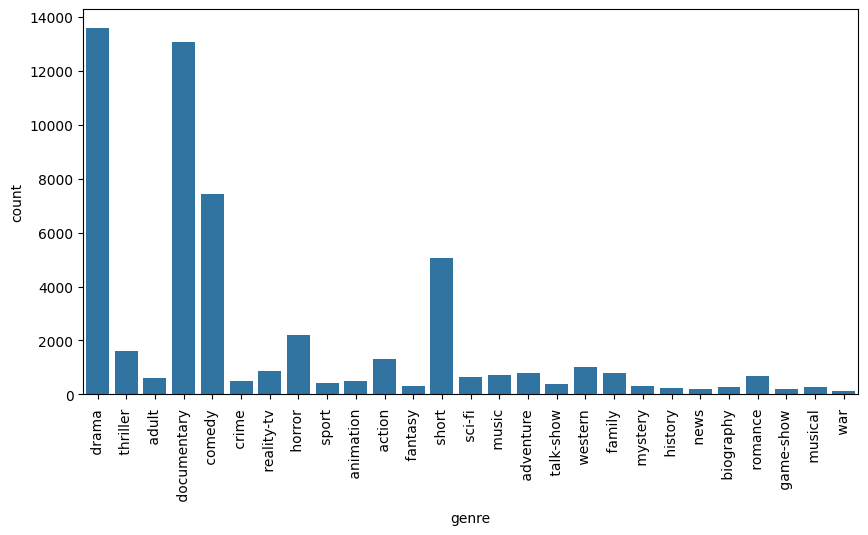

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot(x="genre", data=df_train)
plt.xticks(rotation=90)
plt.show()

##Pre Processing

In [14]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

# Download the punkt and stopwords dataset
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
# for the first pre processing is stemming and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# second pre processing is cleaning text
def cleaning(text):
    # Lowercase all characters
    text = text.lower()

    # Remove Twitter handles
    text = re.sub(r'@\S+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove file extension
    text = re.sub(r'pic.\S+', '', text)

    # replace non-characters with a space
    text = re.sub(r"[^a-zA-Z+']", ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')

    # Use the predefined stop_words variable instead of redefining it inside the function
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)

    # Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])

    # Remove repeated/leading/trailing spaces
    text = re.sub("\s[\s]+", " ", text).strip()
    return text

In [16]:
# Applying the cleaning function to description column
df_train['Text_cleaning'] = df_train['description'].apply(cleaning)
df_test['Text_cleaning'] = df_test['description'].apply(cleaning)

## Build Model

### Using TF-IDF for Vectorizer

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(df_train['Text_cleaning'])

X_test = tfidf.transform(df_test['Text_cleaning'])

### Split Dataset

In [18]:
from sklearn.model_selection import train_test_split

X = X_train
y = df_train['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

lr_model = LogisticRegression(max_iter=1000)
nb_model = MultinomialNB()

In [20]:
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [21]:
nb_model.fit(X_train, y_train)

MultinomialNB()

## Evaluation

In [22]:
print("Linear Regression Score")
lr_model.score(X_test, y_test)

Linear Regression Score


0.5795444065295582

In [23]:
print("Naive Bayes Score")
nb_model.score(X_test, y_test)

Naive Bayes Score


0.44526422576777647

In [24]:
y_pred_lr = lr_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)

In [25]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Linear Regression Accuracy:", accuracy_lr)
print(classification_report(y_test, y_pred_lr, zero_division=1))

Linear Regression Accuracy: 0.5795444065295582
               precision    recall  f1-score   support

      action        0.61      0.21      0.32       263
       adult        0.86      0.17      0.28       112
   adventure        0.45      0.10      0.16       139
   animation        0.67      0.02      0.04       104
   biography        1.00      0.00      0.00        61
      comedy        0.52      0.59      0.55      1443
       crime        1.00      0.01      0.02       107
 documentary        0.65      0.87      0.74      2659
       drama        0.53      0.81      0.64      2697
      family        0.50      0.05      0.10       150
     fantasy        1.00      0.00      0.00        74
   game-show        0.92      0.30      0.45        40
     history        1.00      0.00      0.00        45
      horror        0.67      0.55      0.60       431
       music        0.71      0.38      0.49       144
     musical        1.00      0.00      0.00        50
     mystery     

In [26]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print(classification_report(y_test, y_pred_nb, zero_division=1))

Naive Bayes Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        1.00      0.00      0.00       263
       adult        1.00      0.00      0.00       112
   adventure        1.00      0.00      0.00       139
   animation        1.00      0.00      0.00       104
   biography        1.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        1.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        1.00      0.00      0.00       150
     fantasy        1.00      0.00      0.00        74
   game-show        1.00      0.00      0.00        40
     history        1.00      0.00      0.00        45
      horror        1.00      0.00      0.00       431
       music        1.00      0.00      0.00       144
     musical        1.00      0.00      0.00        50
     mystery        1.

## Prediction

In [30]:
# Prediction using Logistic Regression
def predict_genre_lr(description):
    cleaned_description = cleaning(description)
    vectorized_description = tfidf.transform([cleaned_description])
    prediction = lr_model.predict(vectorized_description)
    return prediction[0]

# Prediction using Naive Bayes
def predict_genre_nb(description):
    cleaned_description = cleaning(description)
    vectorized_description = tfidf.transform([cleaned_description])
    prediction = nb_model.predict(vectorized_description)
    return prediction[0]

# Apply predictions to the test dataset
df_test['Predicted_Genre_LR'] = df_test['description'].apply(predict_genre_lr)
df_test['Predicted_Genre_NB'] = df_test['description'].apply(predict_genre_nb)

# Save the results to a new CSV file
df_test.to_csv('test_data_with_predictions.csv', index=False)

# Display the first few rows of the updated test dataset
df_test.head()

,id,title,description,Text_cleaning,Predicted_Genre_LR,Predicted_Genre_NB
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama,drama
